In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings("ignore")

In [ ]:

# Model Configuration
model_name = "t5-large"
TOKENIZER = T5Tokenizer.from_pretrained(model_name)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL = T5ForConditionalGeneration.from_pretrained(model_name, return_dict=True)
MODEL.to(DEVICE)

# Training Parameters
Q_LEN = 512
T_LEN = 256  # Increased to accommodate answer + distractors
BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 1e-4
OUTPUT_DIR = './models/'
OUTPUT_MODEL_NAME = 'T5--mcq-generation'

In [ ]:
def prepare_data(csv_path):
    df = pd.read_csv(csv_path)
    # Format distractors as comma-separated string if they're not already
    df['Distractors'] = df['Distractors'].apply(lambda x: x if isinstance(x, str) else ', '.join(x) if isinstance(x, list) else str(x))
    
    # Combine correct answer and distractors with special tokens
    df['target_text'] = df.apply(lambda row: f"<answer>{row['Correct Answer']}</answer><distractors>{row['Distractors']}</distractors>", axis=1)
    
    # Format input text with context and question
    df['input_text'] = 'Generate a multiple-choice question (MCQ) based on the given question and context. Ensure the output includes one correct answer and three unique incorrect answers (distractors).   Question: ' + df['Question'] + ' Context: ' + df['Context']
    
    # Print the first 5 formatted examples
    print("\nFirst 5 formatted examples:")
    print("-" * 80)
    for idx in range(min(5, len(df))):
        print(f"\nExample {idx + 1}:")
        print(f"Input text:\n{df['input_text'].iloc[idx]}")
        print(f"\nTarget text:\n{df['target_text'].iloc[idx]}")
        print("-" * 80)
    
    return df[['input_text', 'target_text']]

In [ ]:
#  Custom Dataset class
class MCQGenerationDataset(Dataset):
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.inputs = dataframe['input_text'].values
        self.targets = dataframe['target_text'].values
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = str(self.inputs[idx])
        target_text = str(self.targets[idx])
        
        # Tokenize inputs
        input_encodings = self.tokenizer(input_text, 
                                       max_length=self.q_len,
                                       padding='max_length',
                                       truncation=True,
                                       return_tensors="pt")
        
        # Tokenize targets
        target_encodings = self.tokenizer(target_text,
                                        max_length=self.t_len,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors="pt")
        
        labels = target_encodings['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': labels.squeeze(),
            'decoder_attention_mask': target_encodings['attention_mask'].squeeze()
        }


In [ ]:
# Training function remains the same as your original code
def train_model(train_loader, val_loader, model, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batch_count = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            decoder_attention_mask = batch['decoder_attention_mask'].to(DEVICE)
            
            outputs = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask)
            
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batch_count += 1
        
        avg_train_loss = train_loss / train_batch_count
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                decoder_attention_mask = batch['decoder_attention_mask'].to(DEVICE)
                
                outputs = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              decoder_attention_mask=decoder_attention_mask)
                
                val_loss += outputs.loss.item()
                val_batch_count += 1
        
        avg_val_loss = val_loss / val_batch_count
        val_losses.append(avg_val_loss)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Average validation loss: {avg_val_loss:.4f}")
        
    return train_losses, val_losses

In [ ]:
# Modified generation function for MCQ
def generate_mcq(model, tokenizer, question, context, max_length=256):
    input_text = f"Generate MCQ options: Question: {question} Context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to(DEVICE)
    
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Parse the generated text to extract answer and distractors
    try:
        answer = generated_text.split("<answer>")[1].split("</answer>")[0].strip()
        distractors = generated_text.split("<distractors>")[1].split("</distractors>")[0].strip()
        return {"correct_answer": answer, "distractors": distractors.split(", ")}
    except:
        return {"correct_answer": "", "distractors": []}

In [ ]:

def main():
    # Load and prepare data
    data = prepare_data('/kaggle/input/quizard-mcq-7000/Quizard_MCQ_7000.csv')
    
    # Split data
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = MCQGenerationDataset(TOKENIZER, train_data, Q_LEN, T_LEN)
    val_dataset = MCQGenerationDataset(TOKENIZER, val_data, Q_LEN, T_LEN)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize optimizer and scheduler
    optimizer = Adam(MODEL.parameters(), lr=LEARNING_RATE)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    
    # Train the model
    train_losses, val_losses = train_model(train_loader, val_loader, MODEL, optimizer, scheduler, EPOCHS)
    
    # Plot training results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Save the model
    MODEL.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
    TOKENIZER.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
    
    # Test the model
    sample_question = "What is the largest ocean on Earth?"
    sample_context = "The Pacific Ocean is the largest and deepest ocean on Earth. It covers more than 63 million square miles."
    
    generated_mcq = generate_mcq(MODEL, TOKENIZER, sample_question, sample_context)
    print("\nSample Generation:")
    print(f"Question: {sample_question}")
    print(f"Context: {sample_context}")
    print(f"Correct Answer: {generated_mcq['correct_answer']}")
    print(f"Distractors: {', '.join(generated_mcq['distractors'])}")

if __name__ == "__main__":
    main()

In [ ]:
from kaggle_secrets import UserSecretsClient

# Retrieve the Hugging Face API token from Kaggle secrets
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [ ]:
# Save the fine-tuned model and tokenizer locally
MODEL.save_pretrained("T5-Medium-Test1MCQ-Quizard-5")
TOKENIZER.save_pretrained("T5-Medium-Test1MCQ-Quizard-5")

In [ ]:
# Replace 'your_token' with your actual Hugging Face token
MODEL.push_to_hub("T5-Medium-Test1MCQ-Quizard-5", use_auth_token=hf_token, use_temp_dir=False)
TOKENIZER.push_to_hub("T5-Medium-Test1MCQ-Quizard-5", use_auth_token=hf_token, use_temp_dir=False)

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

def load_model(model_id="aayeshanakarmi/T5-Test1MCQ-Quizard-10", token=hf_token):
    """
    Load the model either from HuggingFace Hub or local path
    """
    try:
        print(f"Loading model from {model_id}...")
        tokenizer = T5Tokenizer.from_pretrained(model_id)
        model = T5ForConditionalGeneration.from_pretrained(model_id)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

def generate_mcq(model, tokenizer, question, context, max_length=256):
    """
    Generate MCQ options using the fine-tuned model
    """
    device = next(model.parameters()).device
    input_text = f"Generate MCQ options: Question: {question} Context: {context}"
    
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate output
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Parse the generated text
    try:
        answer = generated_text.split("<answer>")[1].split("</answer>")[0].strip()
        distractors = generated_text.split("<distractors>")[1].split("</distractors>")[0].strip()
        return {
            "correct_answer": answer,
            "distractors": distractors.split(", "),
            "all_options": [answer] + distractors.split(", ")
        }
    except:
        return {
            "correct_answer": "",
            "distractors": [],
            "all_options": []
        }

# Example usage
if __name__ == "__main__":
    # Load the model
    model, tokenizer, device = load_model()
    
    if model is None:
        print("Failed to load model")
        exit()
    
    # Example questions
    examples = [
        {
            "question": "What is the capital of France?",
            "context": "Paris is the capital and largest city of France. It is located in northern France and is known for its iconic Eiffel Tower."
        },
        {
            "question": "What is photosynthesis?",
            "context": "Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen."
        }
    ]
    
    # Generate MCQs for each example
    print("\nGenerating MCQs...\n")
    for example in examples:
        print("-" * 80)
        print(f"Question: {example['question']}")
        print(f"Context: {example['context']}")
        
        result = generate_mcq(model, tokenizer, example['question'], example['context'])
        
        print("\nGenerated MCQ:")
        print(f"Correct Answer: {result['correct_answer']}")
        print("Distractors:", ", ".join(result['distractors']))
        
        # Print formatted MCQ
        print("\nFormatted MCQ:")
        for i, option in enumerate(result['all_options']):
            print(f"{chr(65+i)}) {option}")
        print(f"\nCorrect Answer: A")  # Since correct answer is always first
        print("-" * 80 + "\n")

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

def load_model(model_id="aayeshanakarmi/T5-Test1MCQ-Quizard-5", token=None):
    """
    Load the model either from HuggingFace Hub or local path
    """
    try:
        print(f"Loading model from {model_id}...")
        tokenizer = T5Tokenizer.from_pretrained(model_id)
        model = T5ForConditionalGeneration.from_pretrained(model_id)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

def generate_mcq(model, tokenizer, question, context, max_length=256):
    """
    Generate MCQ options using the fine-tuned model
    """
    device = next(model.parameters()).device
    input_text = f"Generate MCQ options: Question: {question} Context: {context}"
    
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate output
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("Generated Text:", generated_text)  # Debugging the output text
    
    # Parse the generated text
    try:
        answer = generated_text.split("<answer>")[1].split("</answer>")[0].strip()
        distractors = generated_text.split("<distractors>")[1].split("</distractors>")[0].strip()
        return {
            "correct_answer": answer,
            "distractors": distractors.split(", "),
            "all_options": [answer] + distractors.split(", ")
        }
    except Exception as e:
        print(f"Error parsing the output: {e}")
        return {
            "correct_answer": "Error generating correct answer",
            "distractors": ["Error generating distractors"],
            "all_options": []
        }

# Example usage
if __name__ == "__main__":
    # Load the model
    model, tokenizer, device = load_model()
    
    if model is None:
        print("Failed to load model")
        exit()
    
    # Example questions
    examples = [
        {
            "question": "What is the capital of France?",
            "context": "Paris is the capital and largest city of France. It is located in northern France and is known for its iconic Eiffel Tower."
        },
        {
            "question": "What is photosynthesis?",
            "context": "Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen."
        }
    ]
    
    # Generate MCQs for each example
    print("\nGenerating MCQs...\n")
    for example in examples:
        print("-" * 80)
        print(f"Question: {example['question']}")
        print(f"Context: {example['context']}")
        
        result = generate_mcq(model, tokenizer, example['question'], example['context'])
        
        print("\nGenerated MCQ:")
        print(f"Correct Answer: {result['correct_answer']}")
        print("Distractors:", ", ".join(result['distractors']))
        
        # Print formatted MCQ
        print("\nFormatted MCQ:")
        for i, option in enumerate(result['all_options']):
            print(f"{chr(65+i)}) {option}")
        print(f"\nCorrect Answer: A")  # Since correct answer is always first
        print("-" * 80 + "\n")

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed
)
import wandb
import os
from typing import Dict, List
import random

# Set random seeds for reproducibility
set_seed(42)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Model Configuration
MODEL_NAME = "google/flan-t5-small"  # Can be changed to small/large/xl
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, return_dict=True)
MODEL.to(DEVICE)

# Training Parameters
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 4
OUTPUT_DIR = './models/flan-t5-mcq-7000'

# Instruction template variations for better generalization
INSTRUCTION_TEMPLATES = [
    "Generate a multiple-choice question with one correct answer and three plausible but incorrect options. Question: {question} Context: {context}",
    "Create an MCQ with four options (one correct, three incorrect) based on the following. Question: {question} Context: {context}",
    "Design a multiple-choice question with exactly four options. Include one correct answer and three wrong answers. Question: {question} Context: {context}",
    "Based on the given context, generate a multiple-choice question with four options. Ensure one correct answer and three distinct distractors. Question: {question} Context: {context}"
]

class MCQGenerationDataset(Dataset):
    def __init__(self, tokenizer, dataframe, max_input_length, max_target_length):
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.inputs = []
        self.targets = []
        
        # Process each row with random instruction template
        for _, row in dataframe.iterrows():
            template = random.choice(INSTRUCTION_TEMPLATES)
            input_text = template.format(
                question=row['Question'],
                context=row['Context']
            )
            
            # Format target text with explicit structure
            target_text = (
                f"Correct Answer: {row['Correct Answer']}\n"
                f"Incorrect Options: {row['Distractors']}"
            )
            
            self.inputs.append(input_text)
            self.targets.append(target_text)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = str(self.inputs[idx])
        target_text = str(self.targets[idx])
        
        # Tokenize with proper padding and truncation
        input_encodings = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        
        target_encodings = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        
        # Prepare labels by masking padding tokens
        labels = target_encodings['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': labels.squeeze(),
            'decoder_attention_mask': target_encodings['attention_mask'].squeeze()
        }

def prepare_data(csv_path: str) -> pd.DataFrame:
    """Prepare and validate the dataset."""
    df = pd.read_csv(csv_path)
    
    # Validate data
    required_columns = ['Question', 'Context', 'Correct Answer', 'Distractors']
    assert all(col in df.columns for col in required_columns), f"Missing required columns. Need: {required_columns}"
    
    # Clean and format distractors
    df['Distractors'] = df['Distractors'].apply(
        lambda x: x if isinstance(x, str) else ', '.join(x) if isinstance(x, list) else str(x)
    )
    
    # Validate number of distractors
    df['distractor_count'] = df['Distractors'].str.count(',') + 1
    assert all(df['distractor_count'] >= 3), "Each question must have at least 3 distractors"
    
    return df[required_columns]

def train_model(
    model,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer,
    scheduler,
    num_epochs: int,
    gradient_accumulation_steps: int
) -> tuple:
    """Enhanced training function with gradient accumulation and detailed logging."""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batch_count = 0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")
        optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            decoder_attention_mask = batch['decoder_attention_mask'].to(DEVICE)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask
            )
            
            loss = outputs.loss / gradient_accumulation_steps
            loss.backward()
            
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            train_loss += loss.item() * gradient_accumulation_steps
            train_batch_count += 1
            
            # Update progress bar
            progress_bar.set_postfix({'training_loss': f'{train_loss/train_batch_count:.4f}'})
        
        avg_train_loss = train_loss / train_batch_count
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                decoder_attention_mask = batch['decoder_attention_mask'].to(DEVICE)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    decoder_attention_mask=decoder_attention_mask
                )
                
                val_loss += outputs.loss.item()
                val_batch_count += 1
        
        avg_val_loss = val_loss / val_batch_count
        val_losses.append(avg_val_loss)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Average validation loss: {avg_val_loss:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model.save_pretrained(f"{OUTPUT_DIR}/best_model")
            tokenizer.save_pretrained(f"{OUTPUT_DIR}/best_model")
        
        # Save checkpoint
        if (epoch + 1) % 1 == 0:
            model.save_pretrained(f"{OUTPUT_DIR}/checkpoint-{epoch+1}")
            tokenizer.save_pretrained(f"{OUTPUT_DIR}/checkpoint-{epoch+1}")
    
    return train_losses, val_losses

def generate_mcq(model, tokenizer, question: str, context: str, max_length: int = 256) -> Dict:
    """Generate MCQ with enhanced prompt and output parsing."""
    instruction = random.choice(INSTRUCTION_TEMPLATES)
    input_text = instruction.format(question=question, context=context)
    
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_beams=5,
        length_penalty=1.5,
        early_stopping=True,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    try:
        correct_answer = generated_text.split("Correct Answer:")[1].split("Incorrect Options:")[0].strip()
        distractors = generated_text.split("Incorrect Options:")[1].strip().split(", ")
        
        return {
            "correct_answer": correct_answer,
            "distractors": distractors[:3],  # Ensure exactly 3 distractors
            "all_options": [correct_answer] + distractors[:3]
        }
    except:
        return {"correct_answer": "", "distractors": [], "all_options": []}

def main():
    print(f"Using device: {DEVICE}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    
    # Initialize wandb for experiment tracking
    wandb.init(project="flan-t5-mcq-generation", name="flan-t5-base-mcq")
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load and prepare data
    data = prepare_data('/path/to/your/dataset.csv')
    print(f"Loaded {len(data)} examples")
    
    # Split data
    train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    
    # Create datasets
    train_dataset = MCQGenerationDataset(TOKENIZER, train_data, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
    val_dataset = MCQGenerationDataset(TOKENIZER, val_data, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Calculate total steps for scheduler
    total_steps = len(train_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    
    # Initialize optimizer and scheduler
    optimizer = AdamW(
        MODEL.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.999),
        eps=1e-8
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Train the model
    train_losses, val_losses = train_model(
        MODEL,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        EPOCHS,
        GRADIENT_ACCUMULATION_STEPS
    )
    
    # Plot and save training results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{OUTPUT_DIR}/training_plot.png')
    plt.close()
    
    # Save final model
    MODEL.save_pretrained(f"{OUTPUT_DIR}/final_model")
    TOKENIZER.save_pretrained(f"{OUTPUT_DIR}/final_model")
    
    # Test the model
    test_cases = [
        {
            "question": "What is the largest ocean on Earth?",
            "context": "The Pacific Ocean is the largest and deepest ocean on Earth. It covers more than 63 million square miles."
        },
        {
            "question": "What is photosynthesis?",
            "context": "Photosynthesis is the process by which plants convert sunlight into energy. During this process, plants use sunlight, water, and carbon dioxide to produce glucose and oxygen."
        }
    ]
    
    print("\nGenerating test MCQs:")
    for test_case in test_cases:
        result = generate_mcq(MODEL, TOKENIZER, test_case["question"], test_case["context"])
        print("\n" + "="*50)
        print(f"Question: {test_case['question']}")
        print(f"Context: {test_case['context']}")
        print("\nGenerated MCQ:")
        for i, option in enumerate(result['all_options']):
            print(f"{chr(65+i)}) {option}")
        print(f"\nCorrect Answer: A")

if __name__ == "__main__":
    main()

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Validation Epoch 1/5: 100%|██████████| 179/179 [00:25<00:00,  7.09it/s]


Epoch 1/5 - Train Loss: 1.8045 - Val Loss: 1.4404


Validation Epoch 2/5: 100%|██████████| 179/179 [00:25<00:00,  7.09it/s]


Epoch 2/5 - Train Loss: 1.5193 - Val Loss: 1.3798


Validation Epoch 3/5: 100%|██████████| 179/179 [00:25<00:00,  7.08it/s]


Epoch 3/5 - Train Loss: 1.4246 - Val Loss: 1.3486


Validation Epoch 4/5: 100%|██████████| 179/179 [00:25<00:00,  7.09it/s]


Epoch 4/5 - Train Loss: 1.3567 - Val Loss: 1.3323


Validation Epoch 5/5: 100%|██████████| 179/179 [00:25<00:00,  7.10it/s]


Epoch 5/5 - Train Loss: 1.3055 - Val Loss: 1.3232


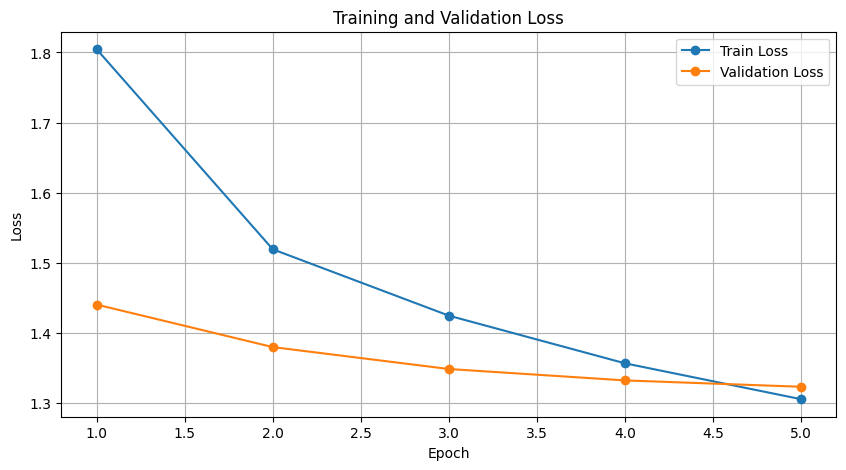


Sample MCQ:
Correct Answer: Pacific Ocean | Incorrect Answers: Atlantic Ocean, Atlantic Ocean, Atlantic Ocean


In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration, Adafactor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Model Configuration
MODEL_NAME = "google/flan-t5-small"  # Use FLAN-T5
TOKENIZER = T5Tokenizer.from_pretrained(MODEL_NAME)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(DEVICE)

# Training Parameters
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 128  # Keep it compact
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-4
OUTPUT_DIR = "./models/"
OUTPUT_MODEL_NAME = "flan-t5-mcq-generation"

# Data Preparation
def prepare_data(csv_path):
    df = pd.read_csv(csv_path)
    df["Distractors"] = df["Distractors"].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) and x.startswith("[") else str(x))
    df["target_text"] = df.apply(lambda row: f"Correct Answer: {row['Correct Answer']} | Incorrect Answers: {row['Distractors']}", axis=1)
    df["input_text"] = df.apply(lambda row: f"Generate a multiple-choice question (MCQ) based on the given question and context. Ensure the output includes one correct answer and three unique incorrect answers (distractors). Question: {row['Question']} Context: {row['Context']}", axis=1)
    return df[["input_text", "target_text"]]

# Custom Dataset
class MCQDataset(Dataset):
    def __init__(self, tokenizer, dataframe, max_input_len, max_target_len):
        self.tokenizer = tokenizer
        self.inputs = dataframe['input_text'].values
        self.targets = dataframe['target_text'].values
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = str(self.inputs[idx])
        target_text = str(self.targets[idx])
        
        input_encodings = self.tokenizer(
            input_text, max_length=self.max_input_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        target_encodings = self.tokenizer(
            target_text, max_length=self.max_target_len, padding='max_length', truncation=True, return_tensors="pt"
        )
        
        labels = target_encodings['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_encodings['input_ids'].squeeze(),
            'attention_mask': input_encodings['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

# Training function
def train_model(train_loader, val_loader, model, optimizer, num_epochs):
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            input_ids, attention_mask, labels = batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE), batch['labels'].to(DEVICE)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                input_ids, attention_mask, labels = batch['input_ids'].to(DEVICE), batch['attention_mask'].to(DEVICE), batch['labels'].to(DEVICE)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

# MCQ Generation Function
def generate_mcq(model, tokenizer, question, context, max_length=128):
    input_text = f"Generate a multiple-choice question (MCQ) based on the given question and context. Ensure the output includes one correct answer and three unique incorrect answers (distractors). Question: {question} Context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(DEVICE)
    outputs = model.generate(inputs["input_ids"], max_length=max_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def main():
    data = prepare_data("/kaggle/input/quizard-mcq-7000/Quizard_MCQ_7000.csv")
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    
    train_dataset = MCQDataset(TOKENIZER, train_data, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
    val_dataset = MCQDataset(TOKENIZER, val_data, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    optimizer = Adafactor(MODEL.parameters(), lr=LEARNING_RATE, relative_step=False)
    
    train_losses, val_losses = train_model(train_loader, val_loader, MODEL, optimizer, EPOCHS)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, EPOCHS+1), val_losses, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    MODEL.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
    TOKENIZER.save_pretrained(f'{OUTPUT_DIR}{OUTPUT_MODEL_NAME}')
    
    sample_question = "What is the largest ocean on Earth?"
    sample_context = "The Pacific Ocean is the largest and deepest ocean on Earth, covering more than 63 million square miles."
    
    print("\nSample MCQ:")
    print(generate_mcq(MODEL, TOKENIZER, sample_question, sample_context))

if __name__ == "__main__":
    main()

In [2]:
# Save the fine-tuned model and tokenizer locally
MODEL.save_pretrained("Flan-T5-Small-Test2-7000MCQ-Quizard-5")
TOKENIZER.save_pretrained("Flan-T5-Small-Test2-7000MCQ-Quizard-5")

('Flan-T5-Small-Test2-7000MCQ-Quizard-5/tokenizer_config.json',
 'Flan-T5-Small-Test2-7000MCQ-Quizard-5/special_tokens_map.json',
 'Flan-T5-Small-Test2-7000MCQ-Quizard-5/spiece.model',
 'Flan-T5-Small-Test2-7000MCQ-Quizard-5/added_tokens.json')

In [3]:
from kaggle_secrets import UserSecretsClient

# Retrieve the Hugging Face API token from Kaggle secrets
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [4]:
# Save to Hugging Face
MODEL.push_to_hub("Flan-T5-Small-Test2-7000MCQ-Quizard-5", use_auth_token=hf_token, use_temp_dir=False)
TOKENIZER.push_to_hub("Flan-T5-Small-Test2-7000MCQ-Quizard-5", use_auth_token=hf_token, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aayeshanakarmi/Flan-T5-Small-Test2-7000MCQ-Quizard-5/commit/13e87b2b720a51ab617552afc2d2c3eb95c15674', commit_message='Upload tokenizer', commit_description='', oid='13e87b2b720a51ab617552afc2d2c3eb95c15674', pr_url=None, repo_url=RepoUrl('https://huggingface.co/aayeshanakarmi/Flan-T5-Small-Test2-7000MCQ-Quizard-5', endpoint='https://huggingface.co', repo_type='model', repo_id='aayeshanakarmi/Flan-T5-Small-Test2-7000MCQ-Quizard-5'), pr_revision=None, pr_num=None)

In [7]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Define device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model name on Hugging Face Hub
MODEL_NAME = "aayeshanakarmi/Flan-T5-Small-Test2-7000MCQ-Quizard-5"  # Change to your actual model repo name

# Load model and tokenizer from Hugging Face Hub
TOKENIZER = T5Tokenizer.from_pretrained(MODEL_NAME)
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(DEVICE)

# Function to generate MCQs
def generate_mcq(model, tokenizer, question, context, max_length=128):
    input_text = f"Generate a multiple-choice question (MCQ) based on the given question and context. Ensure the output includes one correct answer and three unique incorrect answers (distractors). Question: {question} Context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(DEVICE)
    
    outputs = model.generate(inputs["input_ids"], max_length=max_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example inference
sample_question = "What is the largest planet in our solar system?"
sample_context = "Jupiter is the largest planet in our solar system, with a diameter of about 139,820 km."

print("\nGenerated MCQ:")
print(generate_mcq(MODEL, TOKENIZER, sample_question, sample_context))


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]


Generated MCQ:
Correct Answer: Jupiter | Incorrect Answers: Saturn, Mars, Mars
